In [26]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os
import seaborn as sns
import xgboost as xgb

## Lectura del Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = '/content/drive/MyDrive/Colab Notebooks/MachineLearningII'

In [7]:
data_csv = os.listdir(path)
print(data_csv)

['full_data.csv', 'ds_final.csv', 'Machine Learning Models v2.ipynb']


In [8]:
ds = pd.read_csv(path+'/ds_final.csv')

In [9]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       782 non-null    float64
 1   Country                    782 non-null    object 
 2   Happiness Score            782 non-null    float64
 3   GDP per Capita             782 non-null    float64
 4   Life Expectancy            782 non-null    float64
 5   Freedom                    782 non-null    float64
 6   Perceptions of corruption  782 non-null    float64
 7   Generosity                 782 non-null    float64
 8   Region                     782 non-null    object 
dtypes: float64(7), object(2)
memory usage: 55.1+ KB


In [10]:
ds.head()

,Year,Country,Happiness Score,GDP per Capita,Life Expectancy,Freedom,Perceptions of corruption,Generosity,Region
0,2015.0,Switzerland,7.587,1.39651,0.94143,0.66557,0.41978,0.29678,Western Europe
1,2015.0,Iceland,7.561,1.30232,0.94784,0.62877,0.14145,0.43630,Western Europe
2,2015.0,Denmark,7.527,1.32548,0.87464,0.64938,0.48357,0.34139,Western Europe
3,2015.0,Norway,7.522,1.45900,0.88521,0.66973,0.36503,0.34699,Western Europe
4,2015.0,Canada,7.427,1.32629,0.90563,0.63297,0.32957,0.45811,North America


Para el entrenamiento dejaremos fuera la feature 'Country' y 'Year'. Por otro lado crearemos 4 modelos:

- Modelo 1:
    - 'Region' con OHE
    - Variables numericas sin modificar
- Modelo 2:
    - 'Region' con OHE
    - Variables numericas normalizadas
- Modelo 3:
    - Se quita feature 'Region
    - Variables numercias sin modificar
- Modelo 4:
    - Se quita feature 'Region
    - Variables numericas normalizadas

In [11]:
ds.drop(['Country', 'Year'], axis=1, inplace=True)

In [12]:
categoricas = ['Region']
numericas = ['GDP per Capita', 'Life Expectancy','Freedom', 'Perceptions of corruption', 'Generosity']
output =  ['Happiness Score']

In [13]:
ds_2 = ds.drop(['Region'], axis=1, inplace=False)

## Separación en train/test

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

**Dataset 1 con:**
- Features:
    - 'Region'
    - 'GDP per Capita'
    - 'Life Expectancy'
    - 'Freedom'
    - 'Perceptions of corruption'
    - 'Generosity'
- Salida:
    - 'Happiness Score'

In [15]:
ds.head()

,Happiness Score,GDP per Capita,Life Expectancy,Freedom,Perceptions of corruption,Generosity,Region
0,7.587,1.39651,0.94143,0.66557,0.41978,0.29678,Western Europe
1,7.561,1.30232,0.94784,0.62877,0.14145,0.43630,Western Europe
2,7.527,1.32548,0.87464,0.64938,0.48357,0.34139,Western Europe
3,7.522,1.45900,0.88521,0.66973,0.36503,0.34699,Western Europe
4,7.427,1.32629,0.90563,0.63297,0.32957,0.45811,North America


In [16]:
features_1 = ['Region', 'GDP per Capita', 'Life Expectancy',
            'Freedom', 'Perceptions of corruption', 'Generosity']

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    ds[features_1], 
    ds[output],  
    test_size=0.3,
    random_state=42)

In [17]:
print(x_train_1.shape)
print(y_train_1.shape)
print(x_test_1.shape)
print(y_test_1.shape)

(547, 6)
(547, 1)
(235, 6)
(235, 1)


In [18]:
y_train_1_norm = (y_train_1 - y_train_1.min(axis=0)) / (y_train_1.max(axis=0) - y_train_1.min(axis=0))
y_test_1_norm = (y_test_1 - y_test_1.min(axis=0)) / (y_test_1.max(axis=0) - y_test_1.min(axis=0))

**Dataset 2 con:**
- Features:
    - 'GDP per Capita'
    - 'Life Expectancy'
    - 'Freedom'
    - 'Perceptions of corruption'
    - 'Generosity'
- Salida:
    - 'Happiness Score'

In [19]:
ds_2.head()

,Happiness Score,GDP per Capita,Life Expectancy,Freedom,Perceptions of corruption,Generosity
0,7.587,1.39651,0.94143,0.66557,0.41978,0.29678
1,7.561,1.30232,0.94784,0.62877,0.14145,0.43630
2,7.527,1.32548,0.87464,0.64938,0.48357,0.34139
3,7.522,1.45900,0.88521,0.66973,0.36503,0.34699
4,7.427,1.32629,0.90563,0.63297,0.32957,0.45811


In [20]:
features_2 = ['GDP per Capita', 'Life Expectancy', 'Freedom',
              'Perceptions of corruption', 'Generosity']

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(
    ds[features_2], 
    ds[output],  
    test_size=0.3,
    random_state=42)

print(x_train_2.shape)
print(y_train_2.shape)
print(x_test_2.shape)
print(y_test_2.shape)

(547, 5)
(547, 1)
(235, 5)
(235, 1)


In [21]:
y_train_2_norm = (y_train_2 - y_train_2.min(axis=0)) / (y_train_2.max(axis=0) - y_train_2.min(axis=0))
y_test_2_norm = (y_test_2 - y_test_2.min(axis=0)) / (y_test_2.max(axis=0) - y_test_2.min(axis=0))

## Entrenamiento de modelos

In [110]:
# Entrenamiento de modelos de prueba
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import balanced_accuracy_score

def pipeline_ml_models(preprocessing_pipeline):
  # Modelos a ensayar.
  models = [
      ("RandomForest", 
          Pipeline([
              ('preprocessor', preprocessing_pipeline),
              ('model', RandomForestRegressor(n_estimators=200, random_state=42)) 
          ])
      ),
      
      ("Adaboost", 
          Pipeline([
              ('preprocessor', preprocessing_pipeline),
              ('model', AdaBoostRegressor(n_estimators=200, random_state=42)) 
          ])
      ),
      
      ("LinearRegression", 
          Pipeline([
              ('preprocessor', preprocessing_pipeline),
              ('model', LinearRegression())
          ])
      ),
      
      ("LinearRegression_Ridge", 
          Pipeline([
              ('preprocessor', preprocessing_pipeline),
              ('model', Ridge(alpha = 0.001))
          ])
      ),

      ("XGBRegressor", 
          Pipeline([
              ('preprocessor', preprocessing_pipeline),
              ('model', xgb.XGBRegressor(max_depth=3,
                                         learning_rate=0.1,
                                         n_estimators=200,
                                         objective="reg:squarederror",
                                         random_state=42,
                                         reg_lambda = 0.8))
          ])
      ),
      
  ]
  
  return models

### Cadenas de preprocesamiento

In [111]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

#### Modelo 1: 
- 'Region' con OHE
- Variables numericas sin modificar

In [112]:
preprocessing_pipeline1 = ColumnTransformer(
             transformers=[
                           ('categoric', OneHotEncoder(handle_unknown='ignore'),categoricas)
              ],
              remainder='passthrough'
)

model1 = pipeline_ml_models(preprocessing_pipeline1)

#### Modelo 2:
- 'Region' con OHE
- Variables numericas normalizadas

In [113]:
preprocessing_pipeline2 = ColumnTransformer(
             transformers=[
                           ('categoric', OneHotEncoder(handle_unknown='ignore'),categoricas),
                           ("numerical", MinMaxScaler(), numericas)
              ],
              remainder='passthrough'
)

model2 = pipeline_ml_models(preprocessing_pipeline2)

#### Modelo 3:
- Se quita feature 'Region
- Variables numercias sin modificar

In [114]:
preprocessing_pipeline3 = ColumnTransformer(
    # Transformaciones a aplicar a cada columna
             transformers=[
              ],
              remainder='passthrough'
)

model3 = pipeline_ml_models(preprocessing_pipeline3)

#### Modelo 4:
- Se quita feature 'Region
- Variables numericas normalizadas

In [115]:
preprocessing_pipeline4 = ColumnTransformer(
    # Transformaciones a aplicar a cada columna
             transformers=[
                           ("numerical", MinMaxScaler(), numericas)
              ],
              remainder='passthrough'
)

model4 = pipeline_ml_models(preprocessing_pipeline4)

#### Entrenamiento y Resultados

In [116]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

def kfold_pipeline(models_pipeline, samples , target, x_test, y_test, k = 15):
    
    """
    Esta funcion recibe:
        models_pipeline: el pipeline de los modelos a evaluar
        samples: set de entrenamiento
        target: salidas del set de entrenamiento
        x_test: set de testeo
        y_test: set de testeo
        k: el numero de segmentos que utilizara el algoritmo de K-Fold
    """
    results = {}
    for model in models_pipeline:
        model_name = model[0]
        results[model_name] = {}
        
        train_mse = 0
        valid_mse = 0
        
        kf = KFold(n_splits=k)
        kf.get_n_splits(samples)
        
        for train_index, valid_index in kf.split(samples, target):
            x_valid = samples.iloc[valid_index]
            y_valid = target.iloc[valid_index]
            x_train = samples.iloc[train_index]
            y_train = target.iloc[train_index]
            
            model[1].fit(x_train, np.ravel(y_train))
            pred_train = model[1].predict(x_train)
            pred_valid = model[1].predict(x_valid)        
           
            if len(pred_train.shape)>1 and (pred_train.shape[1]>1):
                train_mse = train_mse + mean_squared_error(y_train, pred_train.reshape(-1,1)) / k
                valid_mse = valid_mse + mean_squared_error(y_valid, pred_valid.reshape(-1,1)) / k
            else:
                train_mse = train_mse + mean_squared_error(y_train, pred_train.reshape(-1,1)) / k
                valid_mse = valid_mse + mean_squared_error(y_valid, pred_valid.reshape(-1,1)) / k
        
        pred_test = model[1].predict(x_test)

        results[model_name]["Train"] = train_mse
        results[model_name]["Valid"] = valid_mse
        results[model_name]["Test"] = mean_squared_error(y_test, pred_test.reshape(-1,1))

    models_results = pd.DataFrame(results).T
    return models_results

In [117]:
res1 = kfold_pipeline(model1, x_train_1, y_train_1_norm, x_test_1, y_test_1_norm, k = 5)
res2 = kfold_pipeline(model2, x_train_1, y_train_1_norm, x_test_1, y_test_1_norm, k = 5)
res3 = kfold_pipeline(model3, x_train_2, y_train_2_norm, x_test_2, y_test_2_norm, k = 5)
res4 = kfold_pipeline(model4, x_train_2, y_train_2_norm, x_test_2, y_test_2_norm, k = 5)

#### Resultados de modelos

In [118]:
resultado1 = pd.DataFrame()
resultado2 = pd.DataFrame()
resultado3 = pd.DataFrame()
resultado4 = pd.DataFrame()

In [119]:
resultado1['Train Model 1'] = res1['Train']
resultado1['Test Model 1'] = res1['Test']

resultado2['Train Model 2'] = res2['Train']
resultado2['Test Model 2'] = res2['Test']

resultado3['Train Model 3'] = res3['Train']
resultado3['Test Model 3'] = res3['Test']

resultado4['Train Model 4'] = res4['Train']
resultado4['Test Model 4'] = res4['Test']

In [120]:
train_mse = pd.concat([resultado1['Train Model 1'], resultado2['Train Model 2'], resultado3['Train Model 3'],
                      resultado4['Train Model 4']], axis = 1)
test_mse = pd.concat([resultado1['Test Model 1'], resultado2['Test Model 2'], resultado3['Test Model 3'],
                      resultado4['Test Model 4']], axis = 1)

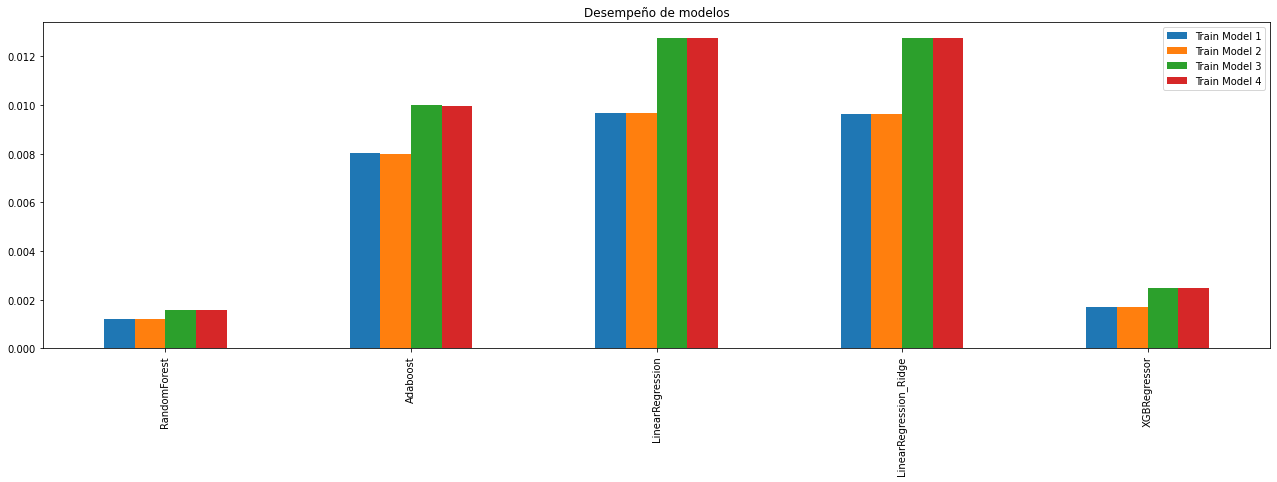

In [121]:
train_mse.plot.bar(title="Desempeño de modelos",figsize=(22,6))

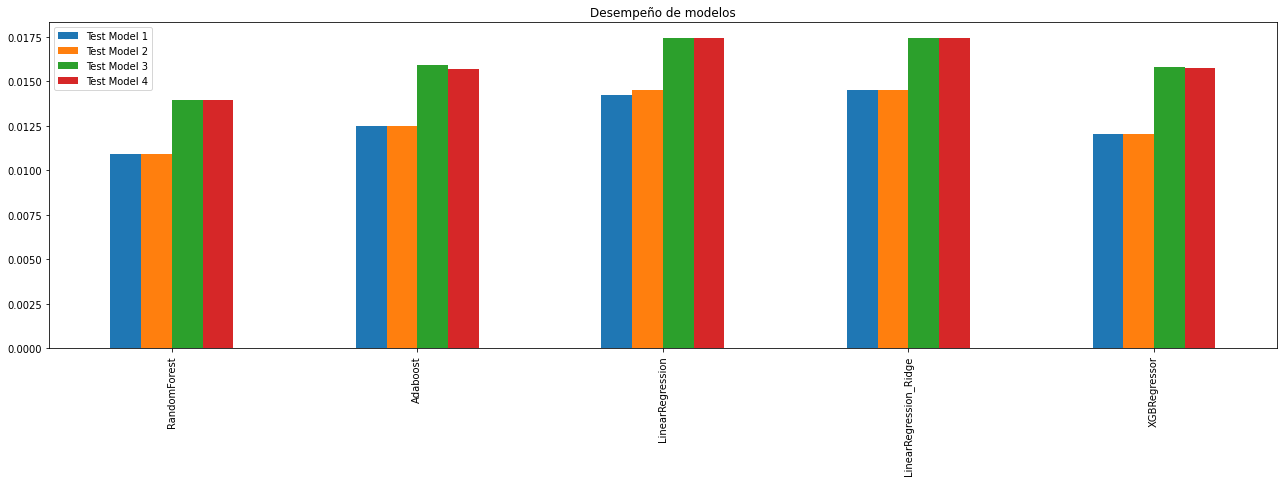

In [122]:
test_mse.plot.bar(title="Desempeño de modelos",figsize=(22,6))

#### Importancia de features

A traves de la libreria xgb podemos realizar un analisis de importancia de features. Aqui podemos ver que en los modelos 1 y 2 tenemos las features f1 a f9  corresponden a las distintas regiones codificadas por ohe. Las features f10 a f14 corresponden a las variables 'GDP per Capita', 'Life Expectancy', 'Freedom', 'Perceptions of corruption', 'Generosity'. Mientras que en los modelos 3 y 4 solo tenemos las features numericas en el mismo orden:

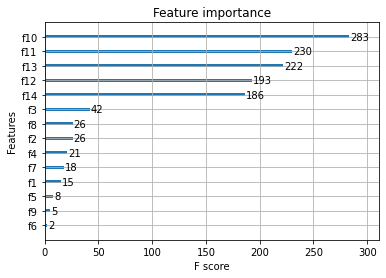

In [123]:
xgb.plot_importance(model1[4][1][1], )

In [124]:
model1[4][1][0]

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('categoric',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='ignore',
                                               sparse=True),
                                 ['Region'])],
                  verbose=False)

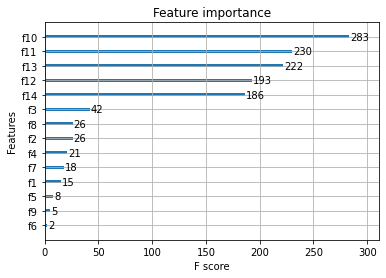

In [125]:
xgb.plot_importance(model2[4][1][1])

In [126]:
model2[4][1][0]

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('categoric',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='ignore',
                                               sparse=True),
                                 ['Region']),
                                ('numerical',
                                 MinMaxScaler(copy=True, feature_range=(0, 1)),
                                 ['GDP per Capita', 'Life Expectancy',
                                  'Freedom', 'Perceptions of corruption',
                                  'Generosity'])],
                  verbose=False)

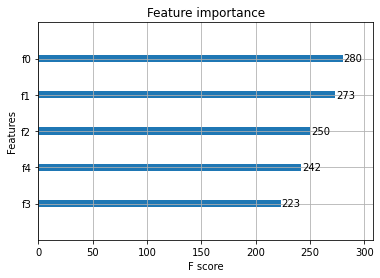

In [127]:
xgb.plot_importance(model3[4][1][1])

In [128]:
model3[4][1][0]

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None, transformers=[], verbose=False)

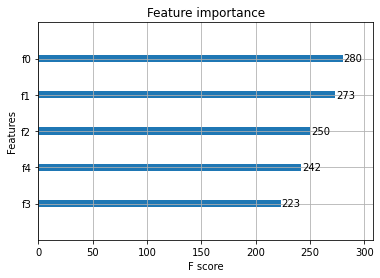

In [129]:
xgb.plot_importance(model4[4][1][1])

In [130]:
model4[4][1][0]

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('numerical',
                                 MinMaxScaler(copy=True, feature_range=(0, 1)),
                                 ['GDP per Capita', 'Life Expectancy',
                                  'Freedom', 'Perceptions of corruption',
                                  'Generosity'])],
                  verbose=False)

Conclusion: Notamos dos cosas de gran importancia. En primer lugar que las variables GDP per capita y Freedom son las variables mas importantes en todos los casos. Por otro lado, notamos que si bien hay gran diferencia entre la importancia que se le da a las regiones en comparacion con las variables numericas, estas si son relevantes a la hora de obtener un buen performance de los modelos como se vio en los resultados anteriores.

## CONCLUSIONES:

Como pudimos analizar la libreria XGBoost nos da poderosas herramientas para el modelado. Si bien la regresion con Extreme Gradient Boosting no tuvo la mejor performance levemente por debajo del Random Forest, superando al resto de los modelos.